<a href="https://colab.research.google.com/github/claredavies/DataScienceCoursework/blob/master/DataScience3Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authenticating Twitter API to Acess


In [1]:
import os
import tweepy as tw
import pandas as pd
import sys 
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
from tweepy import Stream
import time
import datetime

consumer_key= 'HbZzBd5yv2CRH3UkupnNocrkK'
consumer_secret= 'VSWgsXdPBn4MKVKOWzQgUTq3v46Mk9BPnTH2SJd1v60QrbBKOD'
access_token= '1450047668554698752-EmXeaHfLA8lHX6uZWyzHxzTWgsK6nS'
access_token_secret= 'MrGi3pVWAiHGIA6s2gYxG7AHZsNDgf8Eegc7vf7OKg6H8'

# Authenticate to Twitter
auth = tw.OAuthHandler(consumer_key, 
    consumer_secret)
auth.set_access_token(access_token, 
    access_token_secret)

# wait_on_rate_limit=True
api = tw.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


Retrieving Tweets From API

In [46]:
# The search term you want to find
query = "#anxiety -filter:retweets"

until_date = datetime.datetime.now().date()
d = datetime.timedelta(days = 7)
since_date = until_date - d

print("Gathering data across a week between  " + str(since_date) + "  to  " + str(until_date))
print("Please be patient this will take time")

tweets_copy = []
# tweet_mode='extended'
# while True:
tweets = tw.Cursor(api.search,q=query,lang="en",since=since_date, until=until_date,geocode="54.9722,2.4609,650km").items()
# store the API responses in a list
tweet_copy_length = len(tweets_copy)
for tweet in tweets:
    tweets_copy.append(tweet)
if(tweet_copy_length == len(tweets_copy)):
  print("Have all tweets : ", len(tweets_copy))
  # break
print("Tweets length:", len(tweets_copy))
    
print("Total Tweets fetched:", len(tweets_copy))

Gathering data across a week between  2021-10-16  to  2021-10-23
Please be patient this will take time
Tweets length: 615
Total Tweets fetched: 615


Converting Tweets Stored to Panda Dataframe

In [47]:
from datetime import date
import calendar

# intialize the dataframe
tweets_df = pd.DataFrame()

location_data = []

# populate the dataframe
for tweet in tweets_copy:
    location_data.append((tweet.user.screen_name, tweet.user.location))
    hashtags = []
    for hashtag in tweet.entities["hashtags"]:
      hashtags.append(hashtag["text"])
    #         # for text need to call api again with tweet id
    #     text = api.get_status(id=tweet.id, tweet_mode='extended').full_text
    # except:
    #     pass
    tweets_df = tweets_df.append(pd.DataFrame({ 
                                               'tweet_id': tweet.id,
                                               'user_location': tweet.user.location,
                                               'user_screen_name': tweet.user.screen_name,
                                               'user_description': tweet.user.description,
                                               'day': calendar.day_name[tweet.created_at.weekday()],
                                               'hour': tweet.created_at.hour,
                                               'text': tweet.text, 
                                               'hashtags': [' '.join(hashtags)]
                                               }))
    tweets_df = tweets_df.reset_index(drop=True)

# show the dataframe
tweets_df.head(3)

,tweet_id,user_location,user_screen_name,user_description,day,hour,text,hashtags
0,1451693476165341184,"Burnley, England",Crusty_Crouton,Northern Lad. Insurance Broker. Cricket. Snook...,Friday,23,Had a tough night. But I won’t give up #Anxiet...,Anxiety Depression MentalAgeTest MentalHealthM...
1,1451671148572430336,"South East, England",MommaWolf71,I've no idea what I'm doing. I'm just trying t...,Friday,22,Luckily I don't like rollercoasters..... cos m...,anxiety
2,1451657961500258320,United Kingdom,BPDmemoir,CAUTION: \n\nA diary of my own thoughts & feel...,Friday,21,@DaysAdhd I'm also taking cymbalta to help wit...,anxiety


Data Exploration & Clean Up


In [70]:
# check no duplicates (same text)
pd.set_option("display.max_rows", None)
print("Shape of Dataset Before Removing Duplicates:   " + str(tweets_df.shape))
tweets_df.drop_duplicates(subset='text',inplace=True)
tweets_df.drop_duplicates(subset='tweet_id',inplace=True)
print("Shape of Dataset After Removing Duplicates:   " + str(tweets_df.shape))

# remove stop words here
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
new_stop_words = ['-','The','What','_','&']
stop_words.extend(new_stop_words)

tweets_df['text_processed'] = tweets_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
tweets_df['user_description_processed'] = tweets_df['user_description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
tweets_df['hashtags_processed'] = tweets_df['hashtags'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# stemming the words
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
ps = PorterStemmer()
tweets_df['text_processed_stemmed'] = [ps.stem(word) for word in tweets_df['text_processed']]
tweets_df['user_description_processed_stemmed'] = [ps.stem(word) for word in tweets_df['user_description_processed']]
tweets_df['hashtags_processed_stemmed'] = [ps.stem(word) for word in tweets_df['hashtags_processed']]

# print(tweets_df.user_location.value_counts())

Shape of Dataset Before Removing Duplicates:   (614, 12)
Shape of Dataset After Removing Duplicates:   (614, 12)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Plot Time/Day when Axiety Most Talked About

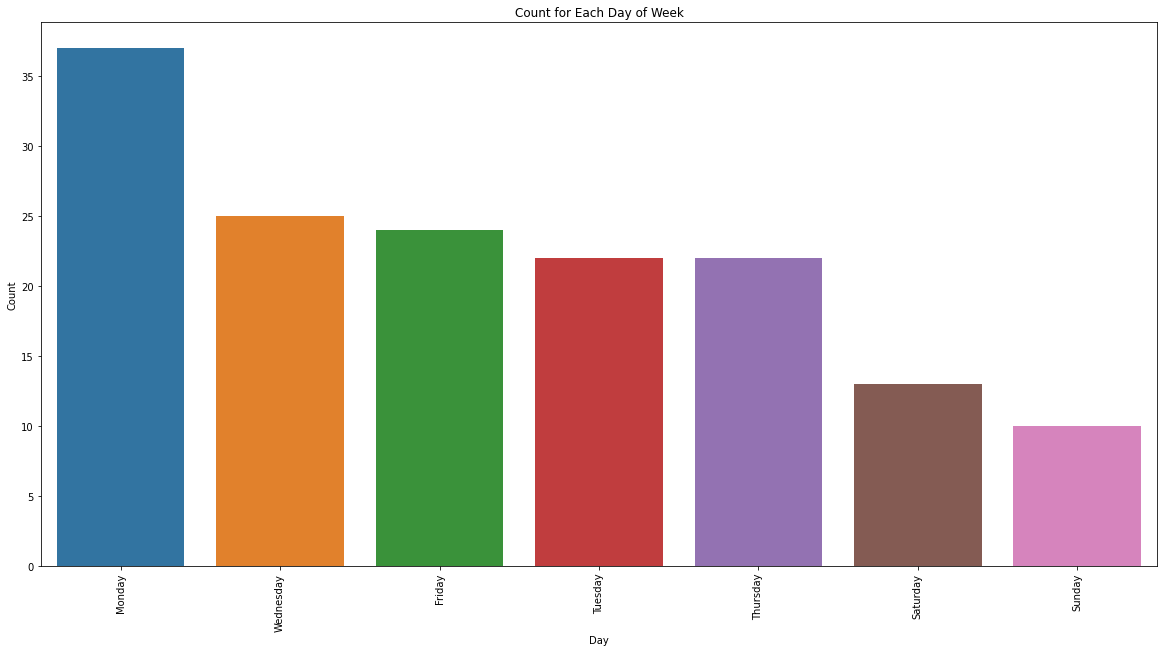

<Figure size 432x288 with 0 Axes>

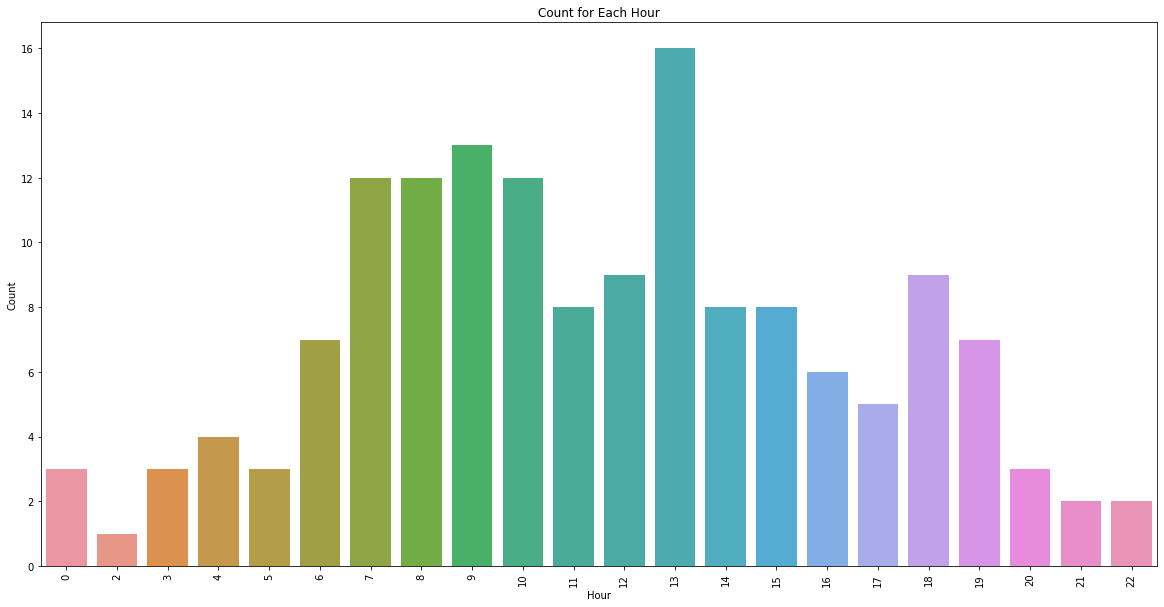

<Figure size 432x288 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, ax1 = plt.subplots()
sns.barplot(x=tweets_df['day'].value_counts(sort=True).index, y=tweets_df['day'].value_counts(sort=True),ax=ax1).set_title("Count for Each Day of Week")
fig_text = plt.gcf()
fig_text.set_size_inches(20, 10)
plt.xticks(rotation=90)
plt.xlabel("Day")
plt.ylabel("Count")
plt.show()
plt.clf()

fig, ax2 = plt.subplots()
sns.barplot(x=tweets_df['hour'].value_counts(sort=True).index, y=tweets_df['hour'].value_counts(sort=True),ax=ax2).set_title("Count for Each Hour")
fig_text = plt.gcf()
fig_text.set_size_inches(20, 10)
plt.xticks(rotation=90)
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()
plt.clf()

Plot How Axiety Talked About via User Description, Hashtags & Tweet Text

Series([], Name: user_description, dtype: object)


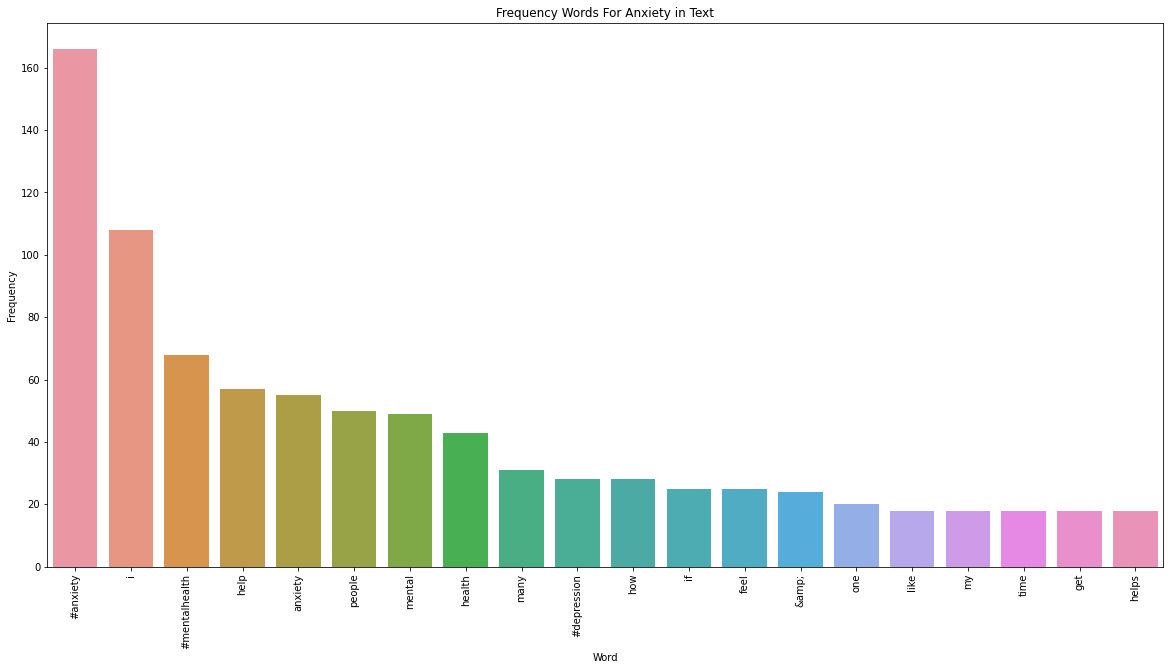

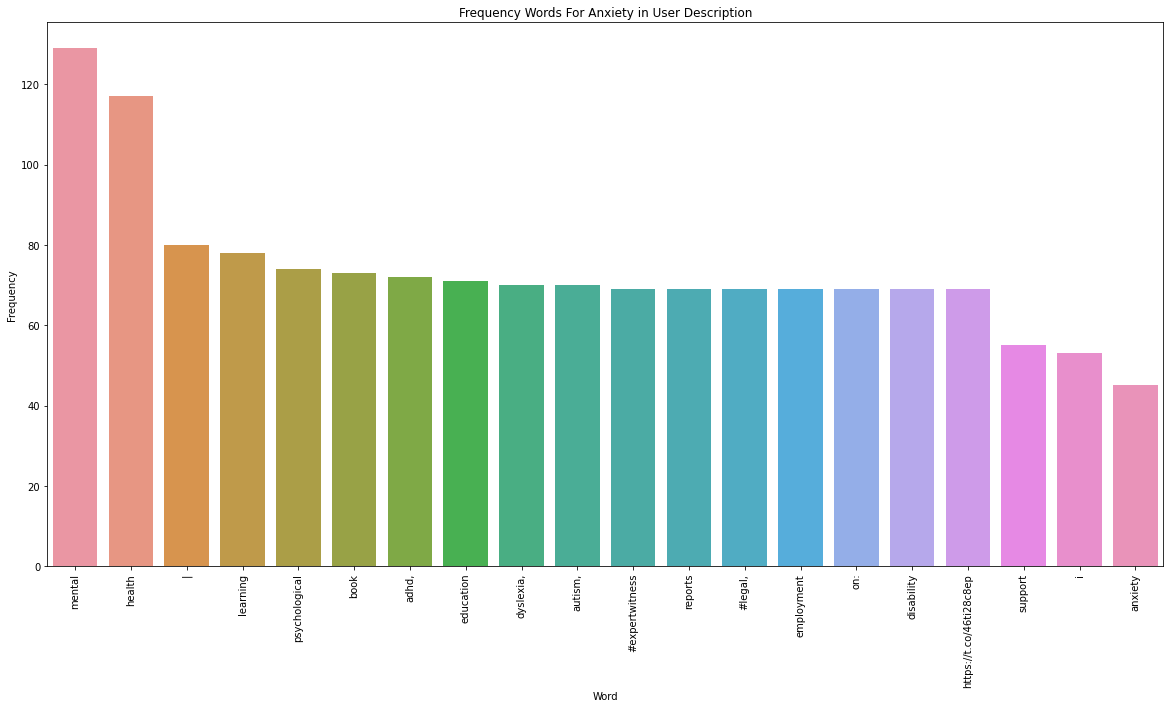

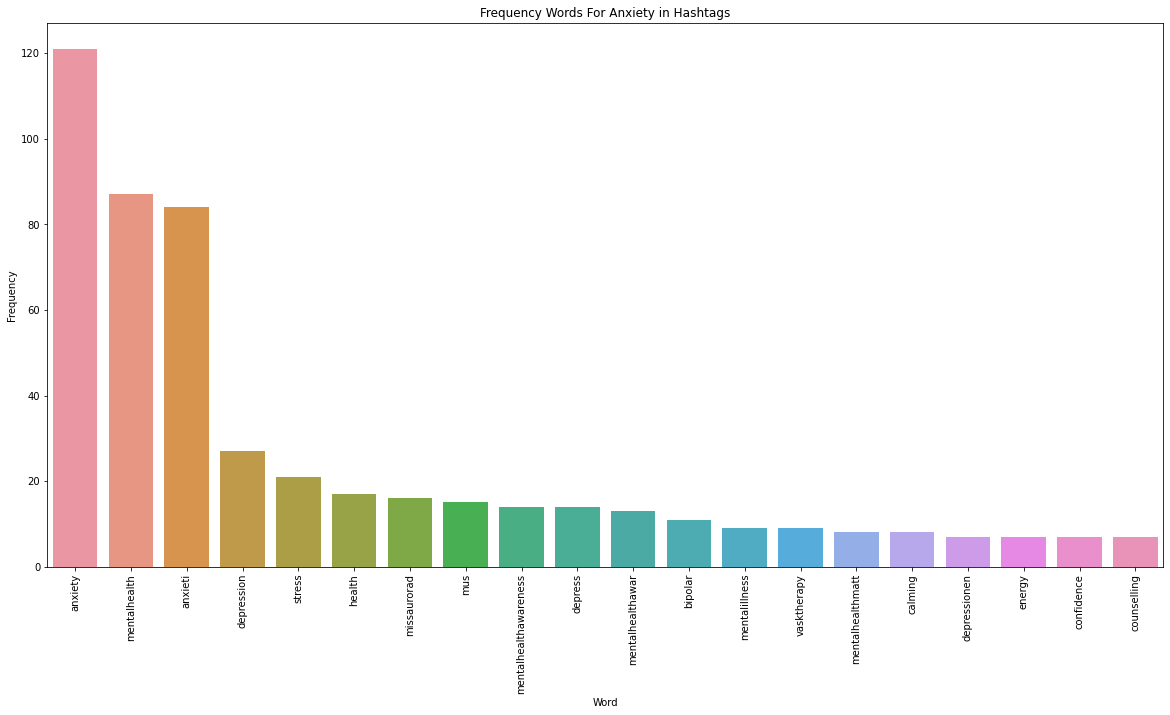

In [71]:
from collections import Counter
import seaborn as sns

# do sentiment analysis
# use word plot

tweets_df['text'] = tweets_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
most_common_words_text = Counter(" ".join(tweets_df['text_processed_stemmed'].str.lower()).split()).most_common(20)
df_words_text = pd.DataFrame.from_records(most_common_words_text, columns=['Word','Frequency'])
fig, ax = plt.subplots()
sns.barplot(x='Word',y='Frequency',data=df_words_text,ax=ax).set_title("Frequency Words For Anxiety in Text")
fig_text = plt.gcf()
fig_text.set_size_inches(20, 10)
plt.xticks(rotation=90)

most_common_words_user_description = Counter(" ".join(tweets_df['user_description_processed_stemmed']).split()).most_common(20)
df_words_user_description = pd.DataFrame.from_records(most_common_words_user_description, columns=['Word','Frequency'])
fig, ax2 = plt.subplots()
sns.barplot(x='Word',y='Frequency',data=df_words_user_description,ax=ax2).set_title("Frequency Words For Anxiety in User Description")
fig_user_description = plt.gcf()
fig_user_description.set_size_inches(20, 10)
plt.xticks(rotation=90)

most_common_words_hashtags = Counter(" ".join(tweets_df['hashtags_processed_stemmed']).split()).most_common(20)
df_words_hashtags = pd.DataFrame.from_records(most_common_words_hashtags, columns=['Word','Frequency'])
fig, ax2 = plt.subplots()
sns.barplot(x='Word',y='Frequency',data=df_words_hashtags,ax=ax2).set_title("Frequency Words For Anxiety in Hashtags")
fig_user_description = plt.gcf()
fig_user_description.set_size_inches(20, 10)
plt.xticks(rotation=90)

print(tweets_df[tweets_df['user_description'].str.contains("Peter")]['user_description'])

Sentiment Analysis

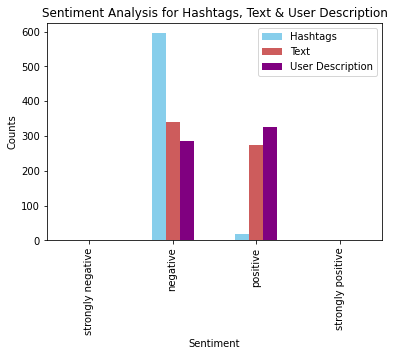

In [100]:
from textblob import TextBlob

tweets_df['sentiment_score_text'] = tweets_df['text_processed_stemmed'].apply(lambda abstract: TextBlob(abstract).sentiment.polarity)
tweets_df['sentiment_score_hashtags'] = tweets_df['hashtags_processed_stemmed'].apply(lambda abstract: TextBlob(abstract).sentiment.polarity)
tweets_df['sentiment_score_user_description'] = tweets_df['user_description_processed_stemmed'].apply(lambda abstract: TextBlob(abstract).sentiment.polarity)

sent_clasification_text = pd.cut(tweets_df['sentiment_score_text'], [-3,-1.2, 0, 1.2 , 3],right=True,include_lowest=True,\
labels=['strongly negative', 'negative', 'positive', 'strongly positive'])
sent_clasification_hashtags = pd.cut(tweets_df['sentiment_score_hashtags'], [-3,-1.2, 0, 1.2 , 3],right=True,include_lowest=True,\
labels=['strongly negative', 'negative', 'positive', 'strongly positive'])
sent_clasification_user_description = pd.cut(tweets_df['sentiment_score_user_description'], [-3,-1.2, 0, 1.2 , 3],right=True,include_lowest=True,\
labels=['strongly negative', 'negative', 'positive', 'strongly positive'])

sent_clasification_hashtags_counts = sent_clasification_hashtags.value_counts()
sent_clasification_text_counts = sent_clasification_text.value_counts()
sent_clasification_user_description_counts = sent_clasification_user_description.value_counts()


df = pd.DataFrame({"Hashtags":sent_clasification_hashtags_counts,"Text":sent_clasification_text_counts,
                 "User Description":sent_clasification_user_description_counts})
ax = df.plot.bar(color=["SkyBlue","IndianRed","Purple"], rot=90, title="Sentiment Analysis for Hashtags, Text & User Description")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Counts")
plt.show()